Data: https://drive.google.com/file/d/1HneKy22aVGKYlSC8p4Cttd6-DKdFdY83/view?usp=sharing

Tutorial: https://github.com/jiuzhangjiangzuo/AICamp1.NLP

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
TRAIN_DIR = '/Users/songyihe/Documents/Study/AI_Projects/large-datasets/english-chinese/segmented_train_seg_by_word.txt'

# Load Data

In [3]:
SENTENCE_LEN = 4

In [4]:
eng_lines, ch_lines = [], []
with open(TRAIN_DIR) as file:
    num_line = 0
    for line in tqdm(file):
        num_line += 1
        if num_line % 2 == 1:
            eng_line = [i.lower() for i in line.strip('\n').split()]
            continue
        else:
            ch_line = [i for i in line.strip('\n').split()]
            
        if len(eng_line) <= SENTENCE_LEN and len(ch_line) <= SENTENCE_LEN:
            eng_lines.append(eng_line)
            ch_lines.append(ch_line)

20000000it [01:12, 274186.24it/s]


In [5]:
print(f'English Lines: {len(eng_lines)}')
print(f'Chinese Lines: {len(ch_lines)}')

English Lines: 150904
Chinese Lines: 150904


In [6]:
print(eng_lines[0])
print(ch_lines[0])

['deuces', 'the', 'winner', '.']
['一对二', '胜', '。']


# Build Vocab

In [7]:
from collections import Counter

In [8]:
vocab = []

for sentence in eng_lines:
    for word in sentence:
        vocab.append(word)
        
for sentence in ch_lines:
    for word in sentence:
        vocab.append(word)

In [9]:
print(f'Most Common Word: {Counter(vocab).most_common(10)}')

Most Common Word: [('.', 69213), ('。', 64997), ('？', 18494), ('?', 18486), ('的', 15156), ('...', 15073), (',', 13814), ('，', 12598), ('the', 11865), ('我', 11374)]


In [10]:
def add_word_to_dict(word2idx, idx2word, word):
    if word in word2idx:
        return
    index = len(word2idx)
    word2idx[word] = index
    idx2word[index] = word

In [11]:
spec_words = ['<pad>','<unk>']
word2idx, idx2word = {}, {}

for word in spec_words:
    add_word_to_dict(word2idx, idx2word, word)
    
for word, _ in Counter(vocab).most_common(10000):
    add_word_to_dict(word2idx, idx2word, word)

In [12]:
print(f'Size of English Dict: {len(word2idx)}')

Size of English Dict: 10002


# Prepare Data

In [13]:
import tensorflow.compat.v1 as tf

In [14]:
data_x_in, data_label = [], []

for eng_line in eng_lines:
    indices = [word2idx.get(word, word2idx['<unk>'])for word in eng_line]
    data_x_in.append(indices)
    data_label.append(1)
    
for ch_line in ch_lines:
    indices = [word2idx.get(word, word2idx['<unk>'])for word in ch_line]
    data_x_in.append(indices)
    data_label.append(0)

In [15]:
print([idx2word[idx] for idx in data_x_in[6]])

['husband', 'and', 'wife', '.']


In [16]:
data_x_in = tf.keras.preprocessing.sequence.pad_sequences(data_x_in, padding='post', 
                                                          value=word2idx['<pad>'])
data_label = np.asarray(data_label)

In [17]:
print(f'data_x_in shape: {data_x_in.shape}')
print(f'data_label shape: {data_label.shape}')

data_x_in shape: (301808, 4)
data_label shape: (301808,)


# Model

In [18]:
import tensorflow.compat.v1 as tf

In [19]:
EMB_SIZE = 100
VOCAB_SIZE = len(idx2word)
HIDDEN_SIZE = 50

In [20]:
rnn_graph = tf.Graph()
with rnn_graph.as_default():      
    ### Initializer
    initializer = tf.random_uniform_initializer(-0.08, 0.08)
    tf.get_variable_scope().set_initializer(initializer)
        
    ### Model Inputs
    x_in = tf.placeholder(dtype=tf.int32, shape=[None, None], name='x_in')
    x_len = tf.placeholder(dtype=tf.int32, shape=[None], name='x_len')
    label = tf.placeholder(dtype=tf.int32, shape=[None], name='label')
    lr = tf.placeholder(dtype=tf.float32, shape=[], name='lr')
        
    ### I.Embedding Layer
    embedding = tf.get_variable(name="embedding", 
                                shape=[VOCAB_SIZE, EMB_SIZE],
                                dtype=tf.float32)
    # embedded_input: [-1, SEQ_LEN, EMB_SIZE]
    embedded_input = tf.nn.embedding_lookup(params=embedding, 
                                            ids=x_in)
        
    ### II.RNN Layer
    lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=HIDDEN_SIZE)
    # state: 2 * [batch_size, HIDDEN_SIZE] (2 for cell state and hidden state in LSTM)
    outputs, state = tf.nn.dynamic_rnn(cell=lstm_cell, 
                                       inputs=embedded_input,
                                       sequence_length=x_len,
                                       time_major=False,
                                       dtype=tf.float32)
    # cell_state: [batch_size, HIDDEN_SIZE]
    cell_state = state[0]
        
    ### III.Classifier
    dense = tf.layers.dense(cell_state, 1)
    output = tf.nn.sigmoid(dense)
        
    # Loss
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.cast(label, tf.float32),
                                                   logits=tf.reshape(dense,(-1,)))
    loss = tf.reduce_mean(loss)
        
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(loss)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


# Train and Predict

In [21]:
BATCH_SIZE = 256

In [22]:
with tf.Session(graph=rnn_graph) as sess:
    sess.run(tf.global_variables_initializer())
    
    # Train
    losses = []
    for epoch in range(0,2):
        data_indices = np.asarray(list(range(len(data_x_in))))
        np.random.shuffle(data_indices)      
        for index in tqdm(range(0, len(data_indices), BATCH_SIZE)):
            batch_indices = data_indices[index: index+BATCH_SIZE]
            batch_x_in = data_x_in[batch_indices]
            batch_x_len = np.asarray([len(i) for i in batch_x_in])
            batch_label = data_label[batch_indices]
            
            _,batch_loss = sess.run([optimizer, loss],feed_dict={
                x_in: batch_x_in,
                x_len: batch_x_len,
                label: batch_label,
                lr: 0.1
            })
            losses.append(batch_loss)
            
    # Predict for a Sample
    sample_sentence = '你 吃 了 吗'
    indices = [word2idx[i.lower()] for i in sample_sentence.split()]
    batch_x_in = np.asarray([indices])
    batch_x_len = np.asarray([len(indices)])
    predict = sess.run(output, feed_dict={
        x_in: batch_x_in,
        x_len: batch_x_len,
    })[0]
    predict_label = '英文' if predict > 0.5 else '中文'
    print(f'{sample_sentence} --> {predict_label} with probability {predict}')

100%|██████████| 1179/1179 [00:14<00:00, 81.77it/s]


你 吃 了 吗 --> 中文 with probability [1.9465012e-06]


<AxesSubplot:>

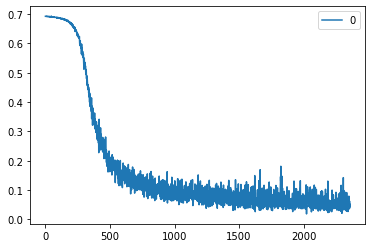

In [23]:
pd.DataFrame(losses).plot()